## Semi-synthetic data generation with IHDP - 5-valued treatment
## Based on Vincent Dorie's NPCI's DGP from https://github.com/vdorie/npci

In [1]:
import sklearn
import numpy as np
import keras
import pandas as pd
import tensorflow as tf

### Read and process covariates

In [37]:
np.random.seed(3)

# Read
covar_file = '/home/bvelasco/Hydranet_script/Input_data/ihdp.csv'
covars = pd.read_csv(covar_file)
#covars.sample(frac=0.01)

bias_size = 100


# Augment data (replicate)
number_of_replications=15
covars = covars.loc[covars.index.repeat(number_of_replications)]
#covars = covars.sample(frac=1).reset_index(drop=True)
covars = covars.reset_index(drop=True)

# Drop unneeded
covars.drop(['Unnamed: 0'], axis=1, inplace=True)

# Fix 'first' var
covars['first'] = covars['first']-1

# Continuous vars
conts = ['bw', 'b.head', 'preterm', 'birth.o', 'nnhealth', 'momage']
# Binary vars
binar = [var for var in list(covars.columns.values) if var not in conts]

# Normalize continuous vars
for col in conts:
    covars[col] = (covars[col]-covars[col].mean())/covars[col].std()
    

### Distribution of example vars before adding noise

<AxesSubplot:>

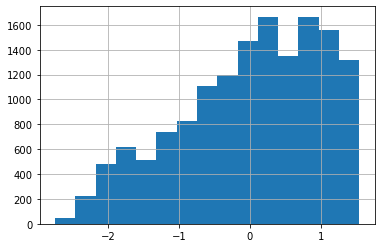

In [38]:
covars.bw.hist(bins=15)

<AxesSubplot:>

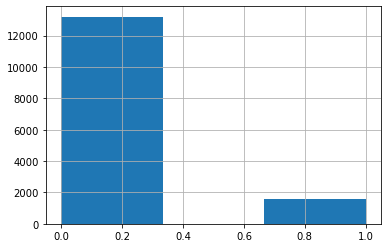

In [39]:
covars.momhisp.hist(bins=3)

In [40]:
# Add noise continuous vars
for col in conts:
    normal_noise = np.random.normal(0,0.8,len(covars))
    uniform_noise = np.random.uniform(-0.5,0.5,len(covars))
    covars[col] = covars[col] + uniform_noise


In [41]:
# Add noise to binary vars
for col in binar:
    binomial_noise = np.random.binomial(1, 0.2, len(covars))
    covars.loc[binomial_noise==0][col] = 1-covars.loc[binomial_noise==0,col]


/home/bvelasco/.conda/envs/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Distribution of var bw after adding noise

<AxesSubplot:>

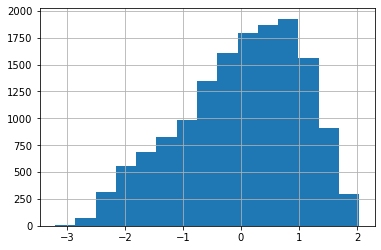

In [42]:
covars.bw.hist(bins=15)

<AxesSubplot:>

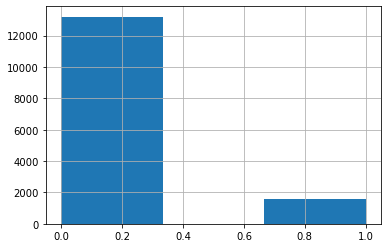

In [43]:
covars.momhisp.hist(bins=3)

### Treatment assignment and Response surfaces

In [44]:
# Paramters
#t_vals = np.array([0,1,2]) # treatment options
t_vals = np.array([0,1,2,3,4])
beta_vals = np.arange(0.0, 0.5, 0.1) # beta values
beta_probs = np.array([0.7, 0.15, 0.1, 0.03, 0.02]) # beta probs
w = np.ones((covars.shape[0], covars.shape[1]-1))*0.5 # offset matrix 
sigma = 1 # std
num_reps = 50


temp_all = pd.DataFrame(columns=['bw', 'b.head', 'preterm', 'birth.o', 'nnhealth', 'momage', 'sex',
       'twin', 'b.marr', 'mom.lths', 'mom.hs', 'mom.scoll', 'cig', 'first',
       'booze', 'drugs', 'work.dur', 'prenatal', 'ark', 'ein', 'har', 'mia',
       'pen', 'tex', 'was', 'momwhite', 'momblack', 'momhisp', 'mu_0', 'mu_1',
       'mu_2', 'mu_3', 'mu_4', 'y_0', 'y_1', 'y_2', 'y_3', 'y_4', 'y', 'z'])
for i in range(num_reps):
    
    # Treatment assignment (probabilistic based on covariate, non-random)
    t_momblack = np.random.choice(t_vals, covars[covars.momblack==1].shape[0],    replace=True, p=np.array([0.8, 0.05, 0.05, 0.05, 0.05]))
    t_momwhite = np.random.choice(t_vals, covars[covars.momwhite==1].shape[0],    replace=True, p=np.array([0.05, 0.8, 0.05, 0.05, 0.05]))
    t_momhisp = np.random.choice(t_vals, covars[covars.momhisp==1].shape[0],      replace=True, p=np.array([0.05, 0.05, 0.8, 0.05, 0.05]))
    t_preterm_big = np.random.choice(t_vals, covars[covars.preterm>8].shape[0],  replace=True, p=np.array([0.05, 0.05, 0.05, 0.8, 0.05]))
    t_preterm_small = np.random.choice(t_vals, covars[(covars.momblack==1) & (covars.preterm<8)].shape[0],replace=True, p=np.array([0.05, 0.05, 0.05, 0.05, 0.8]))
    
    
    covars.loc[(covars['momblack']==1), 'treat'] = t_momblack
    covars.loc[(covars['momwhite']==1), 'treat'] = t_momwhite
    covars.loc[(covars['momhisp']==1), 'treat'] = t_momhisp
    covars.loc[((covars['preterm']>6) & (covars['momhisp']==1)), 'treat'] = t_preterm_big
    covars.loc[((covars['preterm']<6) & (covars['momblack']==1)), 'treat'] = t_preterm_small

    covars.reset_index(inplace=True, drop=True)
    z = covars['treat']
    covars.drop(['treat'], axis=1, inplace=True)
    covars_tab = covars.copy()
    #covars = covars.to_numpy()
    
    # Parameters  
    beta = np.random.choice(beta_vals, covars.shape[1], replace=True, p=beta_probs) # multiplying vector
    w = np.ones((covars.shape))*0.5 # offset matrix 
    
    # Response surface functions (function and sampling from distribution)
    #print(sum(covars.preterm))
    #print(sum(covars.to_numpy()[:,2]))
    #f_0 = lambda x: np.exp(np.matmul((x + w),beta)) + bias_size*x[:,26] # additive term for displacing the mean of the normal distribution based on T
    #f_1 = lambda x: np.log(np.abs(np.matmul(x,beta))+1e-10) + 60*x[:,25]
    #f_2 = lambda x: np.matmul(x,beta) + 40*x[:,27]
    #f_3 = lambda x: np.exp(np.matmul((x + w),beta)) + 10*bias_size*x[:,2]
    #f_4 = lambda x: np.log(np.abs(np.matmul((x + w),beta))+1e-10) + 30*x[:,2]
    #y_f = lambda x: np.random.normal(x, sigma)
    
    f_0 = lambda x: np.exp(np.matmul((x + w),beta)) + bias_size*x[:,26] # additive term for displacing the mean of the normal distribution based on T
    f_1 = lambda x: np.log(np.abs(np.matmul(x,beta))+1e-10) + bias_size*x[:,25]
    f_2 = lambda x: np.matmul(x,beta) + bias_size*x[:,27]
    f_3 = lambda x: np.exp(np.matmul((x + w),beta)) + bias_size*x[:,2]
    f_4 = lambda x: np.log(np.abs(np.matmul((x + w),beta))+1e-10) + bias_size*x[:,2]
    y_f = lambda x: np.random.normal(x, sigma)

    # Compute true effect
    covars_tab['mu_0'] = f_0(covars.to_numpy())
    covars_tab['mu_1'] = f_1(covars.to_numpy())
    covars_tab['mu_2'] = f_2(covars.to_numpy())
    covars_tab['mu_3'] = f_3(covars.to_numpy())
    covars_tab['mu_4'] = f_4(covars.to_numpy())

    # Sample from normal distribution
    covars_tab['y_0'] = y_f(covars_tab.mu_0)
    covars_tab['y_1'] = y_f(covars_tab.mu_1)
    covars_tab['y_2'] = y_f(covars_tab.mu_2)
    covars_tab['y_3'] = y_f(covars_tab.mu_3)
    covars_tab['y_4'] = y_f(covars_tab.mu_4)
    
    y = covars_tab.y_0.copy()
    y[z==0] = covars_tab.y_0[z==0].values
    y[z==1] = covars_tab.y_1[z==1].values
    y[z==2] = covars_tab.y_2[z==2].values
    y[z==3] = covars_tab.y_3[z==3].values
    y[z==4] = covars_tab.y_4[z==4].values

    covars_tab['y'] = y
    covars_tab['z'] = z.astype(int)
    
    temp_all = pd.concat([temp_all, covars_tab], axis=0)

    filename = '/home/bvelasco/Hydranet_script/Input_data/ihdp/five_case/bias_{}/ihdp_five_{}.csv'.format(bias_size,i)
    covars_tab.to_csv(filename)
    

## Statistics

### Confounder proportions

In [11]:
sum(temp_all['momhisp']==1)/len(temp_all)

0.1065989847715736

In [12]:
sum(temp_all['momblack']==1)/len(temp_all)

0.5248730964467005

In [13]:
sum(temp_all['momwhite']==1)/len(temp_all)

0.36852791878172586

### Treatment proportions

In [14]:
print('Percentage of T==0: {}'.format(sum(temp_all['z']==0)/len(temp_all)))
print('Percentage of T==1: {}'.format(sum(temp_all['z']==1)/len(temp_all)))
print('Percentage of T==2: {}'.format(sum(temp_all['z']==2)/len(temp_all)))
print('Percentage of T==3: {}'.format(sum(temp_all['z']==3)/len(temp_all)))
print('Percentage of T==4: {}'.format(sum(temp_all['z']==4)/len(temp_all)))


Percentage of T==0: 0.0499736040609137
Percentage of T==1: 0.3262673434856176
Percentage of T==2: 0.13020642978003383
Percentage of T==3: 0.050548900169204734
Percentage of T==4: 0.4430037225042301


### Mean values of the true effects 

In [15]:
print('True average y_0: {}'.format(temp_all['y_0'].mean()))
print('True average y_1: {}'.format(temp_all['y_1'].mean()))
print('True average y_2: {}'.format(temp_all['y_2'].mean()))
print('True average y_3: {}'.format(temp_all['y_3'].mean()))
print('True average y_4: {}'.format(temp_all['y_4'].mean()))


True average y_0: 19.420460234875126
True average y_1: 9.746794326741856
True average y_2: 3.5789627800990753
True average y_3: 3.6836265107089052
True average y_4: 0.06218989700198979


### Mean values of the observable, biased effects

In [16]:
print('Biased average y0: {}'.format(temp_all.y[temp_all.z==0].mean()))
print('Biased average y1: {}'.format(temp_all.y[temp_all.z==1].mean()))
print('Biased average y2: {}'.format(temp_all.y[temp_all.z==2].mean()))
print('Biased average y3: {}'.format(temp_all.y[temp_all.z==3].mean()))
print('Biased average y4: {}'.format(temp_all.y[temp_all.z==4].mean()))


Biased average y0: 19.40113122403759
Biased average y1: 25.93481164266249
Biased average y2: 20.010237901693504
Biased average y3: 3.5387383987627197
Biased average y4: -0.4689870628784298


### Individual and total bias

In [17]:
print('Bias 0: {}'.format(abs( (temp_all['y_1'].mean() - temp_all['y_0'].mean()) - (temp_all.y[temp_all.z==1].mean() - temp_all.y[temp_all.z==0].mean()) )))
print('Bias 0: {}'.format(abs( (temp_all['y_2'].mean() - temp_all['y_0'].mean()) - (temp_all.y[temp_all.z==2].mean() - temp_all.y[temp_all.z==0].mean()) )))
print('Bias 0: {}'.format(abs( (temp_all['y_3'].mean() - temp_all['y_0'].mean()) - (temp_all.y[temp_all.z==3].mean() - temp_all.y[temp_all.z==0].mean()) )))
print('Bias 0: {}'.format(abs( (temp_all['y_4'].mean() - temp_all['y_0'].mean()) - (temp_all.y[temp_all.z==4].mean() - temp_all.y[temp_all.z==0].mean()) )))


Bias 0: 16.207346326758167
Bias 0: 16.450604132431963
Bias 0: 0.1255591011086512
Bias 0: 0.5118479490428847


In [18]:
b1 = abs((temp_all.y[temp_all.z==1].mean() - temp_all.y[temp_all.z==0].mean()) - (temp_all.y_1 - temp_all.y_0).mean()) 
b2 = abs((temp_all.y[temp_all.z==2].mean() - temp_all.y[temp_all.z==0].mean()) - (temp_all.y_2 - temp_all.y_0).mean()) 
b3 = abs((temp_all.y[temp_all.z==3].mean() - temp_all.y[temp_all.z==0].mean()) - (temp_all.y_3 - temp_all.y_0).mean()) 
b4 = abs((temp_all.y[temp_all.z==4].mean() - temp_all.y[temp_all.z==0].mean()) - (temp_all.y_4 - temp_all.y_0).mean()) 

In [19]:
print('Bias 0: {}'.format(b1))
print('Bias 1: {}'.format(b2))
print('Bias 2: {}'.format(b3))
print('Bias 3: {}'.format(b4))


Bias 0: 16.207346326757403
Bias 1: 16.450604132431227
Bias 2: 0.12555910110891944
Bias 3: 0.5118479490433998


In [20]:
b1 = abs((temp_all.y[temp_all.z==1].mean() - temp_all.y[temp_all.z==0].mean()) - (temp_all.y_1 - temp_all.y_0).mean()) / abs(temp_all.y_1 - temp_all.y_0).mean() * 100
b2 = abs((temp_all.y[temp_all.z==2].mean() - temp_all.y[temp_all.z==0].mean()) - (temp_all.y_2 - temp_all.y_0).mean()) / abs(temp_all.y_2 - temp_all.y_0).mean() * 100
b3 = abs((temp_all.y[temp_all.z==3].mean() - temp_all.y[temp_all.z==0].mean()) - (temp_all.y_3 - temp_all.y_0).mean()) / abs(temp_all.y_3 - temp_all.y_0).mean() * 100
b4 = abs((temp_all.y[temp_all.z==4].mean() - temp_all.y[temp_all.z==0].mean()) - (temp_all.y_4 - temp_all.y_0).mean()) / abs(temp_all.y_4 - temp_all.y_0).mean() * 100

In [21]:
print('Bias 0 perc: {}'.format(b1))
print('Bias 1 perc: {}'.format(b2))
print('Bias 2 perc: {}'.format(b3))
print('Bias 3 perc: {}'.format(b4))


Bias 0 perc: 57.678734203664504
Bias 1 perc: 76.23986354031527
Bias 2 perc: 0.3968994665248542
Bias 3 perc: 1.5423075716192745


In [22]:
print('total: {}'.format(b1+b2+b3+b4))

total: 135.85780478212388


### Save parameters

### Individual histograms

<AxesSubplot:>

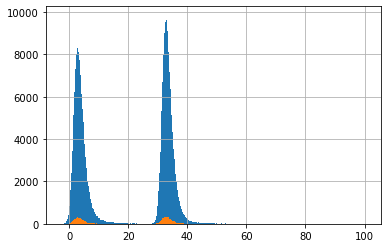

In [23]:
temp_all.y_0.hist(bins=1000)
temp_all.y[temp_all.z==0].hist(bins=1000)

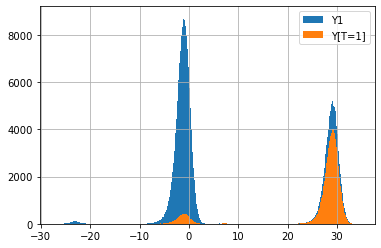

In [24]:
ax=temp_all.y_1.hist(bins=1000)
temp_all.y[temp_all.z==1].hist(bins=1000)
ax.legend(['Y1', 'Y[T=1]']);
fig = ax.get_figure()
fig.savefig('{}_y1_y_1.pdf'.format(bias_size))

In [25]:
print('Y_1 mean and std: {}, {}'.format(covars_tab.y_1.mean(), covars_tab.y_1.std()))

print('Y[T=1] mean and std: {}, {}'.format(covars_tab.y[covars_tab.z==1].mean(), covars_tab.y[covars_tab.z==1].std()))

Y_1 mean and std: 9.95578502867522, 14.810680791423435
Y[T=1] mean and std: 26.420594586499547, 8.97662669496386


<AxesSubplot:>

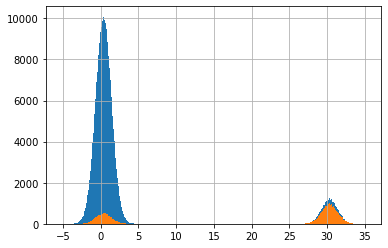

In [26]:
temp_all.y_2.hist(bins=1000)
temp_all.y[temp_all.z==2].hist(bins=1000)

<AxesSubplot:>

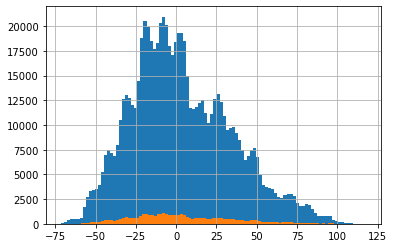

In [27]:
temp_all.y_3.hist(bins=100)
temp_all.y[temp_all.z==3].hist(bins=100)

<AxesSubplot:>

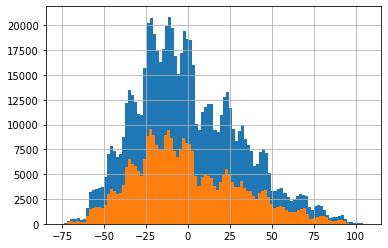

In [28]:
temp_all.y_4.hist(bins=100)
temp_all.y[temp_all.z==4].hist(bins=100)

### ATE histograms. THIS IS CONCEPTUALLY WRONG!!!!

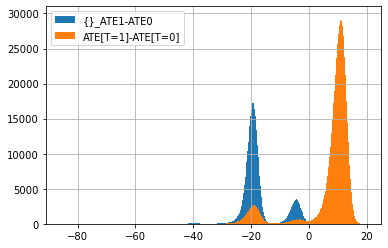

In [28]:
ax = (temp_all.y_1-temp_all.y_0).hist(bins=1000)
(temp_all.y[temp_all.z==1]-temp_all.y[temp_all.z==0]).hist(bins=1000)
ax.legend(['{}_ATE1-ATE0', 'ATE[T=1]-ATE[T=0]'.format(bias_size)]);

<AxesSubplot:>

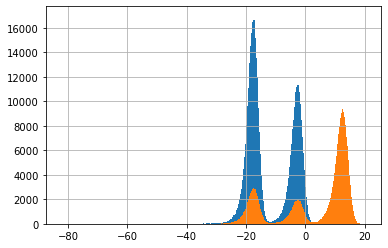

In [29]:
(temp_all.y_2-temp_all.y_0).hist(bins=1000)
(temp_all.y[temp_all.z==2]-temp_all.y[temp_all.z==0]).hist(bins=1000)

<AxesSubplot:>

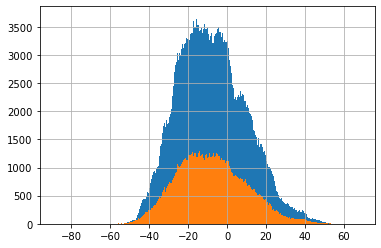

In [30]:
(temp_all.y_3-temp_all.y_0).hist(bins=1000)
(temp_all.y[temp_all.z==3]-temp_all.y[temp_all.z==0]).hist(bins=1000)

<AxesSubplot:>

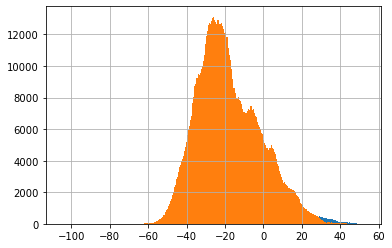

In [31]:
(temp_all.y_4-temp_all.y_0).hist(bins=1000)
(temp_all.y[temp_all.z==4]-temp_all.y[temp_all.z==0]).hist(bins=1000)